In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# payments

In [19]:
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 3
C = 1

# Exponents for the Beta functions
p = (alpha - 1)/alpha  # = 2/3
q = (alpha + 1)/alpha  # = 4/3

# Complete Beta function B(p,q)
B_pq = mp.betainc(p, q, 0, 1)  # This is the full Beta integral from 0 to 1

def I(b):
    """
    I(b) = ∫[z=b..∞] [z^(-alpha) / (z^(-alpha) + C)^2] dz.
    For alpha=3, C=1, it becomes (1/3)[B(2/3,4/3) - B_x(2/3,4/3)].
    """
    # x = C / (b^(-alpha) + C) = 1 / (b^(-3) + 1)
    x = C/(b**(-alpha) + C)
    
    # Lower incomplete Beta function B_x(p,q) = ∫[t=0..x] t^(p-1)*(1-t)^(q-1) dt
    Bx_pq = mp.betainc(p, q, 0, x)  # lower incomplete Beta from 0 to x
    
    return (C**(1/alpha - 1)/alpha)*(B_pq - Bx_pq)

# We'll sample b on a log-spaced or linear-spaced grid:
b_vals = np.linspace(0.01, 10, 200)  # from b=0.01 to b=10
I_vals = [I(b) for b in b_vals]

In [20]:
def allo(b):
    return b**(-alpha) / (C + b**(-alpha))

In [21]:
allos = [allo(b) for b in b_vals]

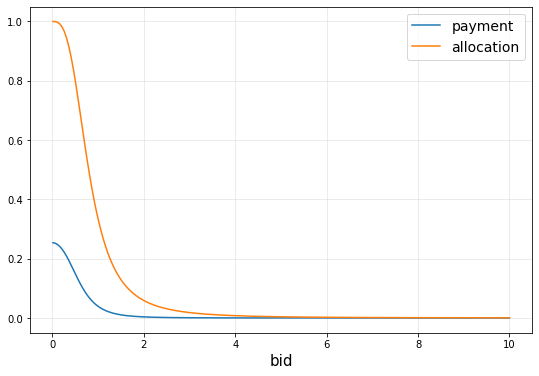

In [18]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(b_vals, I_vals, label=r'payment')
ax.plot(b_vals, allos, label=r'allocation')


ax.set_xlabel(r'bid', size=15)
ax.legend(fontsize=14)
ax.grid(alpha=0.3)

plt.show()

In [43]:
def integral_z_alpha(alpha, C, b):
    """
    Computes the definite integral:
    I(alpha, C, b) = ∫[z=b..∞] z^(-alpha) / (z^(-alpha) + C)^2 dz
    
    Parameters:
    -----------
    alpha : float > 0
    C     : float > 0
    b     : float > 0
    
    Returns:
    --------
    Value of the integral as a float.
    """
    # Define p and q for the Beta functions
    p = (alpha - 1) / alpha
    q = (alpha + 1) / alpha
    
    # Complete Beta function B(p,q)
    # mpmath.betainc(p, q, 0, 1) gives the integral from 0 to 1
    B_pq = mp.betainc(p, q, 0, 1)
    
    # Lower incomplete Beta function:
    # betainc(p, q, 0, x) corresponds to ∫[0..x] t^(p-1)*(1-t)^(q-1) dt
    x = C / (b**(-alpha) + C)
    Bx_pq = mp.betainc(p, q, 0, x)
    
    # Combine everything according to the closed-form expression
    factor = -C**(1/alpha) 
    return factor * (B_pq - Bx_pq)

def allo(alpha, C, b):
    return b**(-alpha) / (C + b**(-alpha))

In [44]:
b_vals = np.linspace(0.01, 10, 200)  
Cs     = [0.1, 1, 10]
alpha  = 3

payments = []
allos    = []
for C in Cs:
    payments.append([integral_z_alpha(alpha, C, b) for b in b_vals])
    allos.append([allo(alpha, C, b) for b in b_vals])
payments = np.array(payments)
allos    = np.array(allos)
payments.shape, allos.shape

((3, 200), (3, 200))

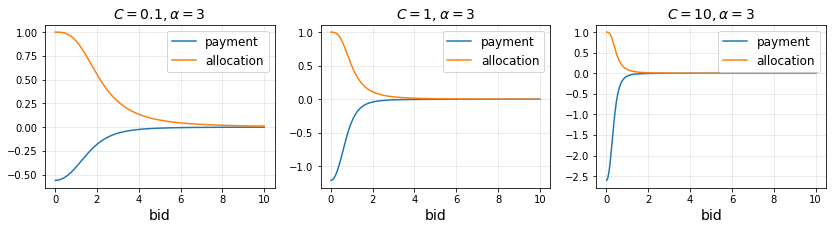

In [46]:
f, axarr = plt.subplots(ncols=3, figsize=(14,3))


for i, ax in enumerate(axarr):
    ax.plot(b_vals, payments[i], label=r'payment')
    ax.plot(b_vals, allos[i], label=r'allocation')

    ax.set_xlabel(r'bid', size=14)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)
    ax.set_title(r'$C={}, \alpha=3$'.format(Cs[i]), size=14)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# optimization

In [2]:
def F(x, c, alpha):
    vals  = np.array([c[i]*np.power(x[i], 1+1/alpha) for i in range(len(c))])
    return np.sum(vals)

In [3]:
def Theos(c, alpha):
    den = sum(np.power(c, -alpha))
    return np.power(c, -alpha)/den

In [4]:
c = np.array([1,10,4,3])
alpha = 3.

In [5]:
start_pos = [1/len(c) for i in range(len(c))]
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
bnds = tuple((0,1) for x in start_pos)

res = minimize(
    F, 
    start_pos, 
    method      = 'SLSQP',
    args        = (c, alpha),
    bounds      = bnds, 
    constraints = cons, 
    tol=1e-16
)
res

     fun: 0.9827270017283498
     jac: array([1.31030267, 1.31030309, 1.31030267, 1.31030268])
 message: 'Optimization terminated successfully'
    nfev: 153
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([9.49070941e-01, 9.49064375e-04, 1.48292259e-02, 3.51507689e-02])

In [6]:
Theos(c, alpha=3.)

array([0.94907092, 0.00094907, 0.01482923, 0.03515077])

# optimization with a capped constraint.

In [80]:
def F(x, c, alpha):
    vals  = np.array([c[i]*np.power(x[i], 1+1/alpha) for i in range(len(c))])
    return np.sum(vals)

In [104]:
def solve_constrained(c, alpha):
    """
    Solve:
        min sum_j c[j]* (x[j])^(1+1/alpha)
        s.t. sum_j x[j] = 1,  0 <= x[j] <= 1 - 1/alpha.
    Returns: x (array)
    """
    n = len(c)
    c = np.array(c, dtype=float)  # ensure floats
    
    # Quick feasibility check
    if n * (1 - 1/alpha) < 1.0:
        raise ValueError("Infeasible: not enough 'room' to sum to 1.")
    
    # We'll store the final x in x_sol
    x_sol = np.zeros(n, dtype=float)
    
    # Set of indices not yet clamped:
    active = list(range(n))
    
    # How much "mass" is left to allocate
    mass_left = 1.0
    
    # While we still have variables to solve for:
    while len(active) > 0:
        
        # Among the active set, compute denominators
        c_inv_alpha = np.power(c[active], -alpha)
        denom = np.sum(c_inv_alpha)
        
        # Proposed unconstrained solution for each j in active
        x_u = (c_inv_alpha / denom) * mass_left
        
        # Check if we need to clamp any x_u[j]
        too_big = [j for (j, val) in zip(active, x_u) if val > (1 - 1/alpha)]
        
        if len(too_big) == 0:
            # None of them violate the upper bound => we are done
            for (j, val) in zip(active, x_u):
                x_sol[j] = val
            break
        else:
            # At least one violates => clamp them
            for j in too_big:
                x_sol[j] = 1 - 1/alpha
            # So we remove those from the active set
            # and reduce the mass_left accordingly
            for j in too_big:
                active.remove(j)
                mass_left -= (1 - 1/alpha)
                
            # If mass_left < 1e-15 or so, we might be effectively done
            # but let's continue if needed

    return x_sol

In [126]:
c = np.array([1,2,3,4,5])
alpha = 4/3

In [127]:
start_pos = [1/len(c) for i in range(len(c))]
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})

# MODIFY THE BNDS
bnds = tuple((0,1-1/alpha) for x in start_pos)

res = minimize(
    F, 
    start_pos, 
    method      = 'SLSQP',
    args        = (c, alpha),
    bounds      = bnds, 
    constraints = cons, 
    tol=1e-16
)
res

     fun: 0.761026920667263
     jac: array([0.61871842, 1.23743684, 1.73551665, 1.73551662, 1.73551662])
 message: 'Optimization terminated successfully'
    nfev: 168
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([0.25      , 0.25      , 0.22857354, 0.15575463, 0.11567183])

In [128]:
solve_constrained(c, alpha=alpha)

array([0.25      , 0.25      , 0.22857354, 0.15575463, 0.11567183])

In [129]:
Theos(c, alpha)

array([0.52564586, 0.2086027 , 0.12148749, 0.08278404, 0.06147991])

In [132]:
Theos(c[1:], alpha) * 0.75

array([0.32982114, 0.19208354, 0.13088961, 0.09720572])

In [133]:
Theos(c[2:], alpha) * 0.5

array([0.22857354, 0.15575463, 0.11567183])

# Two player optimal capped. 

##  c0 = 1, c1 = cs
### plot the allocations and the ratio of the optimal to the equilibrium.

In [139]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [140]:
def F(x, c, alpha):
    vals  = np.array([c[i]*np.power(x[i], 1+1/alpha) for i in range(len(c))])
    return np.sum(vals)

In [156]:
def getOptimalAllos(cs, a):
    start_pos = [1/len(cs) for i in range(len(cs))]
    cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
    bnds = tuple((0,1-1/alpha) for x in start_pos)
    res = minimize(
        F, 
        start_pos, 
        method      = 'SLSQP',
        args        = (cs, alpha),
        bounds      = bnds, 
        constraints = cons, 
        tol=1e-16
    )
    return res.x

In [146]:
alpha = 3.
c1s   = np.arange(1, 7.01, 0.1)
c1s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1,
       6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. ])

In [147]:
guesses = c1s

In [172]:
xTildes = []
xStars  = []

scrs    = []
fratios = []

for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    bids    = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(bids, a=alpha)
    xTildes.append(xTilde)
    
    xStar = getOptimalAllos(costs, alpha)
    xStars.append(xStar)

    scrs.append(np.dot(xTilde, costs)/np.dot(xStar, costs))
    fratios.append(F(xTilde, costs, alpha)/F(xStar, costs, alpha))

xStars  = np.asarray(xStars)
xTildes = np.asarray(xTildes)
scrs    = np.asarray(scrs)
fratios = np.asarray(fratios)
xTildes.shape, xStars.shape, scrs.shape, fratios.shape

((61, 2), (61, 2), (61,), (61,))

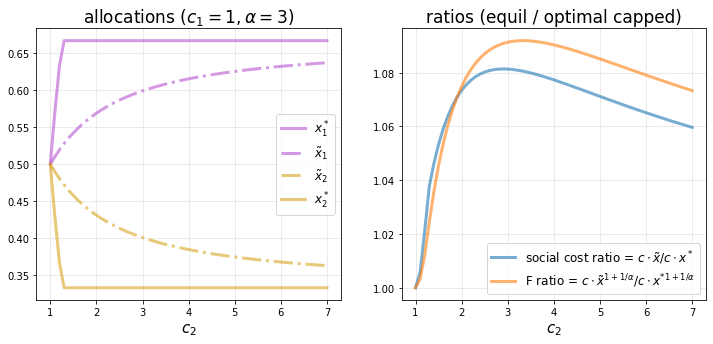

In [178]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xStars[:,0], linewidth=3, alpha=0.6, label=r'$x^*_1$', color='mediumorchid',
              linestyle='-')
axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')
axarr[0].plot(c1s, xStars[:,1], linewidth=3, alpha=0.6, label=r'$x^*_2$', color='goldenrod',
              linestyle='-')

axarr[1].plot(c1s, scrs, linewidth=3, alpha=0.6, label=r'social cost ratio = $c\cdot\tilde{x}/c\cdot x^*$')
axarr[1].plot(c1s, fratios, linewidth=3, alpha=0.6, label=r'F ratio = $c\cdot\tilde{x}^{1+1/\alpha}/c\cdot x^{*1+1/\alpha}$')

for ax in axarr:
    ax.legend(prop={'size': 12})
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
axarr[0].set_title(r'allocations $(c_1=1, \alpha=3)$', size=17)
axarr[1].set_title(r'ratios (equil / optimal capped)', size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# alpha objective vs social cost tradeoff

In [2]:
def F(x, c, alpha):
    vals  = np.array([c[i]*np.power(x[i], 1+1/alpha) for i in range(len(c))])
    return np.sum(vals)

In [42]:
c = np.array([1, 2])
theos = Theos(c, alpha=3.)
theos, F(theos, c, alpha=3.)

(array([0.88888889, 0.11111111]), 0.9614997135382722)

In [28]:
F(theos, c, alpha=3.), F(np.array([1,0]), c, alpha=3.), np.dot(theos, c), np.dot(np.array([1,0]), c)

(0.9614997135382722, 1.0, 1.1111111111111112, 1)

In [44]:
# Q: the worst-case social cost is [1,R] is that true of the objective function
# - yes

In [46]:
# can we add social cost to the optimization function?

In [47]:
def F(x, c, alpha):
    vals  = np.array([c[i]*np.power(x[i], 1+1/alpha) for i in range(len(c))])
    alpha_obj   = np.sum(vals)
    social_cost = np.dot(x, c)
    return alpha_obj + social_cost

In [52]:
c = np.array([1,1.4])
alpha = 3.

In [53]:
start_pos = [1/len(c) for i in range(len(c))]
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
bnds = tuple((0,1) for x in start_pos)

res = minimize(
    F, 
    start_pos, 
    method      = 'SLSQP',
    args        = (c, alpha),
    bounds      = bnds, 
    constraints = cons, 
    tol=1e-16
)
res

     fun: 1.9738570959030513
     jac: array([2.28430064, 2.28430066])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.89368378, 0.10631622])

In [54]:
Theos(c, alpha=3.)

array([0.73290598, 0.26709402])

In [ ]:
def F(x, c, alpha):
    vals  = np.array([c[i]*np.power(x[i], 1+1/alpha) for i in range(len(c))])
    alpha_obj   = np.sum(vals)
    social_cost = np.dot(x, c)
    return alpha_obj + social_cost

In [ ]:
c = np.array([1,1.4])
alpha = 3.

In [56]:
# max social cost

In [57]:
def Theos(c, alpha):
    den = sum(np.power(c, -alpha))
    return np.power(c, -alpha)/den

def Cost(c, x):
    return np.dot(c, x)

In [60]:
c = np.array([1,4])
x = Theos(c, 3.)
Cost(c, x)

1.0461538461538462

In [72]:
c = np.array([1,4])
x = Theos(c, 3.)
Cost(c, x)

1.0461538461538462

# maximizing the function

In [128]:
# NEGATIVE to maximize
def F(c, alpha):
    x_is  = np.power(c, -alpha) / np.sum(np.array([np.power(c[i], -alpha) for i in range(len(c))]))
    vals  = np.array([c[i]*np.power(x_is[i], 1+1/alpha) for i in range(len(c))])
    alpha_obj = np.sum(vals)
    return -alpha_obj

In [132]:
c = np.array([1,2])
alpha = 3.

In [135]:
start_pos = [1/len(c) for i in range(len(c))]
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
bnds = tuple((1,2) for x in start_pos)

In [136]:
res = minimize(
    F, 
    start_pos, 
    method      = 'SLSQP',
    args        = (alpha),
    bounds      = bnds, 
    tol=1e-16
)
res

     fun: -1.5874010519681996
     jac: array([-0.39685027, -0.39685027])
 message: 'Optimization terminated successfully'
    nfev: 9
     nit: 4
    njev: 3
  status: 0
 success: True
       x: array([2., 2.])

# maximizing the function

In [341]:
# NEGATIVE to maximize
def F(c, alpha, N):
    sorted_c = np.sort(c)
    subCs    = sorted_c[:N]
    x1s    = np.power(subCs, -alpha) / np.sum(np.array([np.power(subCs[i], -alpha) for i in range(len(subCs))]))
    val1s  = np.array([subCs[i]*np.power(x1s[i], 1+1/alpha) for i in range(len(subCs))])
    
    x2s    = np.power(c, -alpha) / np.sum(np.array([np.power(c[i], -alpha) for i in range(len(c))]))
    val2s  = np.array([c[i]*np.power(x2s[i], 1+1/alpha) for i in range(len(c))])
    
    num = np.sum(val1s)
    den = np.sum(val2s)
    
    return -num/den

In [348]:
F(np.array([1,1,1]), alpha=2.0, N=2)

-1.2247448713915892

In [405]:
(2)**(1/2.)

1.4142135623730951

In [1]:
alpha = 2.
R = 10
# N < R^{alpha-1}
n = 5
N = 2
start_pos = np.array([1, 1])
bnds = tuple((1,10) for x in start_pos)

res = minimize(
    F, 
    start_pos, 
    method      = 'SLSQP',
    args        = (alpha, N),
    bounds      = bnds, 
    tol=1e-16,
    options={'ftol':1e-16, 'maxiter':1000}
)
res.x, res.fun, (n/N)**(1/alpha)

NameError: name 'np' is not defined

In [337]:
def TheoMax(n,N,alpha,R):
    return np.power(N,-1/alpha) * np.power(N + (n-N)*np.power(R, -alpha), 1/alpha)

In [231]:
TheoMax(n=n,N=N,alpha=alpha,R=R)

1.0013315594956687

In [364]:
N

2

In [363]:
F(np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), alpha=3., N=N)

-1.7099759466766966

In [365]:
5**(1/3.)

1.7099759466766968

In [253]:
### GENERATED 


def alpha_objective_ratio(c, alpha, N):
    """
    Compute the ratio:

        num = sum_{i in top-subset} c_i * [ (c_i^-alpha) / sum_{j in top-subset} c_j^-alpha ]^(1+1/alpha)
        den = sum_{i in full-set} c_i * [ (c_i^-alpha) / sum_{j in full-set} c_j^-alpha ]^(1+1/alpha)

    Here, we interpret "top-subset" as the first N items in c[:N]
    (or whichever subset logic you want).
    """
    # Ensure c is a numpy array:
    c = np.array(c)
    m = len(c)
    
    # --- Numerator: using c[:N] ---
    # subCs = c[:N]  # if you truly want the first N in the array to form the subset
    # Alternatively, if you want the N smallest in c, do:
    subCs = np.sort(c)[:N]
    
    # 1) negative-power sums for the subset
    subPow = np.power(subCs, -alpha)
    sumSubPow = np.sum(subPow)
    # allocations in top-subset
    xSub = subPow / sumSubPow
    
    # each term = c_i * (x_i)^(1+1/alpha)
    valSub = subCs * np.power(xSub, 1.0 + 1.0/alpha)
    num = np.sum(valSub)
    
    # --- Denominator: using full c ---
    fullPow = np.power(c, -alpha)
    sumFullPow = np.sum(fullPow)
    # allocations in full-set
    xFull = fullPow / sumFullPow
    
    # each term = c_i * (x_i)^(1+1/alpha)
    valFull = c * np.power(xFull, 1.0 + 1.0/alpha)
    den = np.sum(valFull)
    
    # ratio = num / den
    return num / den

def alpha_objective_negative(c, alpha, N):
    """
    Return the *negative* of the ratio, to use with 'minimize'.
    """
    return - alpha_objective_ratio(c, alpha, N)


In [358]:
alpha = 2.0         # exponent
N = 2               # size of "top" subset
m = 3               # total dimension (len(c))
R = 10.0            # upper bound

# We'll define an initial guess. Must be in (1,R) for all c_i:
# e.g. pick the midpoint (1+R)/2 = 5.5
start_c = np.array([9,2.,3.])

# Define bounds: each c_i in (1,R). We'll use (1+1e-6, R-1e-6) to avoid endpoints
bnds = [(1+1e-6, R-1e-6) for _ in range(m)]

# Call scipy minimize
res = minimize(
    alpha_objective_negative,     # objective
    start_c,                      # initial guess
    args=(alpha, N),             # extra arguments for the objective
    method='SLSQP',
    bounds=bnds,
    options={'ftol':1e-16}
)

print("Optimization result:", res)
print("Optimal c:", res.x)
print("Max ratio =", -res.fun)

Optimization result:      fun: -1.2247448711318485
     jac: array([0.04408123, 0.02423275, 0.06030333])
 message: 'Iteration limit reached'
    nfev: 1119
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([6.76991473, 6.76991472, 6.76991473])
Optimal c: [6.76991473 6.76991472 6.76991473]
Max ratio = 1.2247448711318485


In [379]:
# find solution with algebra
# Define symbols
N, n, a, R = sp.symbols('N n alpha R', real=True, positive=True)

# Define the equation
equation = sp.Eq((n / N)**(1 / alpha), 1+(N-1)/a * (a/(a-1))**(1-a))
equation

Eq((n/N)**(1/alpha), 1 + (alpha/(alpha - 1))**(1 - alpha)*(N - 1)/alpha)

In [382]:
sp.simplify(equation)

Eq((n/N)**(1/alpha), (alpha + (alpha/(alpha - 1))**(1 - alpha)*(N - 1))/alpha)

In [400]:
alpha_val = 2

# Substitute alpha = 1 into the equation
eq_alpha1 = equation.subs({alpha: alpha_val})

In [401]:
sp.simplify(eq_alpha1)

Eq(10/sqrt(N), N/4 + 3/4)

In [402]:
solution_alpha2 = sp.solve(eq_alpha1, N)
solution

[]

In [394]:
solution = sp.solve(eq_alpha1, N)
solution

[]